

# LAB 3






> *   MAZOUZ ABDERAHIM
*   M1


---






# PART 1

In [ ]:
import re
from transformers import DistilBertTokenizer , DistilBertModel
from collections import defaultdict,Counter
import torch
from sklearn.model_selection import train_test_split

In [94]:
def get_gender(text):
  # Regular expression pattern to match Gender attribute and its value
  regex_pattern = r'Gender=([^\|]+)'
  # Search for the gender using the regex pattern
  match = re.search(regex_pattern,text)
  if match:
    # Extract the gender from the match
    gender = match.group(1)
  else:
    gender = "none"
  return gender

In [92]:
!git clone "https://github.com/UniversalDependencies/UD_German-GSD.git" #Downloading German data
!git clone "https://github.com/UniversalDependencies/UD_French-Sequoia" #Downloading French data

Cloning into 'UD_German-GSD'...
remote: Enumerating objects: 1922, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1922 (delta 220), reused 288 (delta 219), pack-reused 1633
Receiving objects: 100% (1922/1922), 67.04 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (1397/1397), done.
Cloning into 'UD_French-Sequoia'...
remote: Enumerating objects: 458, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 458 (delta 109), reused 108 (delta 55), pack-reused 295
Receiving objects: 100% (458/458), 4.13 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (310/310), done.


In [99]:
def occurences(path,tokenizer):
  # Create a defaultdict to store distributions for each gender
  gender_subtoken_distribution = defaultdict(list)


  with open(path,'r') as File:

    for line in File:


      if (len(line.split())) == 10:
        word = line.split()[2]
        pos = line.split()[3]
        gender = get_gender(line.split()[5])


        if pos=="NOUN" and (gender in ["Fem","Masc","Neut"]):

          tokens = tokenizer.tokenize(word)
          num_subtokens = len(tokens)
          gender_subtoken_distribution[gender].append(num_subtokens)



  for gender, subtoken_counts in gender_subtoken_distribution.items():

      print("Gender:", gender)
      number_counts = Counter(subtoken_counts)
      for number, count in number_counts.items():
        print(f"number of subtokens: {number} occurs {count} times.")

In [100]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert/distilbert-base-german-cased")
path = "/content/UD_German-GSD/de_gsd-ud-train.conllu"
occurences(path,tokenizer)

Gender: Fem
number of subtokens: 1 occurs 11409 times.
number of subtokens: 2 occurs 4383 times.
number of subtokens: 4 occurs 800 times.
number of subtokens: 3 occurs 2128 times.
number of subtokens: 5 occurs 223 times.
number of subtokens: 7 occurs 19 times.
number of subtokens: 6 occurs 61 times.
number of subtokens: 8 occurs 5 times.
number of subtokens: 12 occurs 1 times.
number of subtokens: 10 occurs 1 times.
number of subtokens: 11 occurs 1 times.
Gender: Neut
number of subtokens: 1 occurs 6703 times.
number of subtokens: 2 occurs 2122 times.
number of subtokens: 4 occurs 332 times.
number of subtokens: 3 occurs 952 times.
number of subtokens: 5 occurs 96 times.
number of subtokens: 7 occurs 6 times.
number of subtokens: 6 occurs 34 times.
number of subtokens: 8 occurs 1 times.
number of subtokens: 9 occurs 1 times.
Gender: Masc
number of subtokens: 1 occurs 10112 times.
number of subtokens: 2 occurs 3917 times.
number of subtokens: 3 occurs 1647 times.
number of subtokens: 4 o

In [104]:
tokenizer = DistilBertTokenizer.from_pretrained("Geotrend/distilbert-base-en-fr-cased")
path = "/content/UD_French-Sequoia/fr_sequoia-ud-train.conllu"
occurences(path,tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

Gender: Fem
number of subtokens: 1 occurs 3164 times.
number of subtokens: 2 occurs 720 times.
number of subtokens: 3 occurs 565 times.
number of subtokens: 5 occurs 124 times.
number of subtokens: 4 occurs 235 times.
number of subtokens: 6 occurs 5 times.
number of subtokens: 7 occurs 1 times.
Gender: Masc
number of subtokens: 1 occurs 3918 times.
number of subtokens: 2 occurs 825 times.
number of subtokens: 3 occurs 485 times.
number of subtokens: 4 occurs 149 times.
number of subtokens: 5 occurs 45 times.
number of subtokens: 6 occurs 5 times.
number of subtokens: 7 occurs 1 times.
number of subtokens: 9 occurs 1 times.
number of subtokens: 10 occurs 1 times.


# Part 2

## Pre-processing Data

### Loading data

In [ ]:
!pip install datasets

In [18]:
# Loading the dataset

from datasets import load_dataset

dataset = load_dataset("amazon_polarity")

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
dbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [19]:
# Small sample
content = dataset['train']['content'][:1000]
labels = dataset['train']['label'][:1000]

### Building embedding matrices

In [30]:
# Get CLS embedding

def get_embedding_cls(batch):
  tokenized_batch = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')

  with torch.no_grad():
    output = dbert(**tokenized_batch)

  return output['last_hidden_state'][:, 0, :]

In [48]:
# Get the mean embedding

def get_embedding_mean(batch):
  tokenized_batch = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')

  with torch.no_grad():
    output = dbert(**tokenized_batch)

  return torch.mean(output['last_hidden_state'],axis=1)

In [47]:
w = get_embedding_mean(content[1:2])

w = torch.mean(w,axis=1)

w.shape

torch.Size([1, 768])

In [ ]:
# Move the model to GPU if available
#dbert.to('cuda')

In [49]:
batch_size = 50
all_cls_embeddings = []
all_mean_embeddings = []

for i in range(0,len(content),batch_size):

  print(f'batch : {i}:{i+batch_size}')

  # Build CLS matrice
  batch_embedding = get_embedding_cls(content[i:i+batch_size])
  all_cls_embeddings.append(batch_embedding)

  # Build mean matrice
  batch_embedding = get_embedding_mean(content[i:i+batch_size])
  all_mean_embeddings.append(batch_embedding)

all_cls_embeddings = torch.cat(all_cls_embeddings)
all_mean_embeddings = torch.cat(all_mean_embeddings)

batch : 0:50
batch : 50:100
batch : 100:150
batch : 150:200
batch : 200:250
batch : 250:300
batch : 300:350
batch : 350:400
batch : 400:450
batch : 450:500
batch : 500:550
batch : 550:600
batch : 600:650
batch : 650:700
batch : 700:750
batch : 750:800
batch : 800:850
batch : 850:900
batch : 900:950
batch : 950:1000


## Training phase


### for CLS strategy

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import numpy as np


X = all_cls_embeddings.cpu().numpy() # Move the tensor to CPU
y = labels

# Splitting data into Train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0,max_iter=1000,solver="saga").fit(X_train, y_train)

In [55]:
CLS_score = clf.score(X_test,y_test)
print("The accuracy using CLS strategy is :", CLS_score)


The accuracy using CLS strategy is : 0.87


### for MEAN pooling strategy

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



X = all_mean_embeddings.cpu().numpy() # Move the tensor to CPU
y = labels

# Splitting data into Train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0,max_iter=1000,solver="saga").fit(X_train, y_train)

In [67]:
MEAN_score = clf.score(X_test,y_test)
print("The accuracy using MEAN strategy is :", clf.score(X_test,y_test))

The accuracy using MEAN strategy is : 0.9


## Using CountVectoriser

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5, stop_words="english")
data = cv.fit_transform(content[:1000])

train_X, test_X, train_Y, test_Y = train_test_split(data, y[:1000], test_size=0.10, random_state=42)
clf1 = LogisticRegression(random_state=0,max_iter=1000,solver="saga").fit(X_train, y_train)

In [78]:
CountVectorizer_score = clf1.score(X_test,y_test)
print("The accuracy using countvectorizer strategy is :", CountVectorizer_score)

The accuracy using countvectorizer strategy is : 0.9


## Visualization

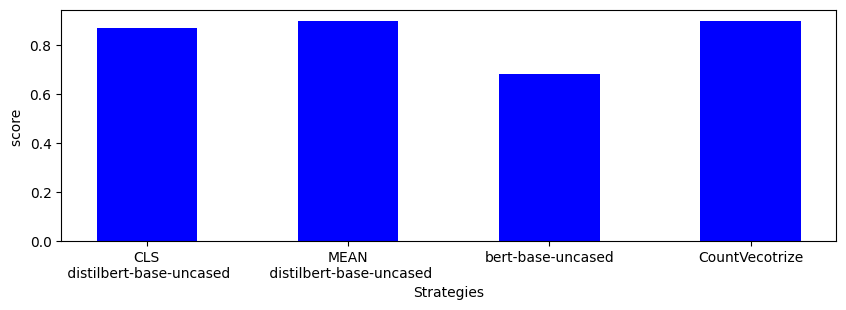

In [89]:
import matplotlib.pyplot as plt

data = {"CLS\n distilbert-base-uncased":CLS_score,
        "MEAN\n distilbert-base-uncased":MEAN_score,
        "bert-base-uncased":0.68,
        "CountVecotrize":CountVectorizer_score}

strategy = list(data.keys())
scores = list(data.values())

fig = plt.figure(figsize = (10, 3))

# creating the bar plot
plt.bar(strategy, scores, color ='blue',
        width = 0.5)

plt.xlabel("Strategies")
plt.ylabel("score ")
#plt.title("")
plt.show()

Based on the sentiment analysis results obtained:


*   CountVectorizer strategy and MEAN strategy both yield a high accuracy of 90%

*   CLS strategy achieves a slightly lower accuracy of 87%.


*   However, when using the CLS strategy with the bert-base-uncased model, the accuracy drops significantly to 68%.



Overall, it appears that CountVectorizer and MEAN strategies perform equally well and outperform the CLS strategy in terms of accuracy